# Individual Data Generation Example
For the individual data generation, the probability to have a true positive label is dependant on the previous predictions for the individual. The number of positive and negative predictions defines, how close an individual is to the decision boundary.

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from aif360.algorithms.inprocessing import PrejudiceRemover

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.individual_data_generator import DataGenerator as IndDataGen
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

Import error: No module named 'tensorflow'


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The unconstrained clf, same as before.
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)   

## 1. Unconstrained Example
Again, an unconstrained classifier is trained first. In this case a linear support vector machine. In the first generation, both baseline and true data are identical.

Because the svm is unconstrained, it perfectly distinguishes the data points. Hence, the number of positive and negative labels does not change with time again in the true data case. 

Contrary, in the baseline data, the whole negative group slowly moves towards the positive cluster with time.

In [4]:
# The data generator, same as before expect for different means.
generator = IndDataGen(mean_pos=[0, 1],
                       mean_neg=[8, 9],
                       num_positive_label=50,
                       num_negative_label=50,
                       discrimination_factor=.9)

In [5]:
# The AIF metric for long term prediction.
metric = AifLongTermMetric()

In [6]:
# The clf.
clf = CLF(LinearSVC())

In [7]:
# The ltf plot generator.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

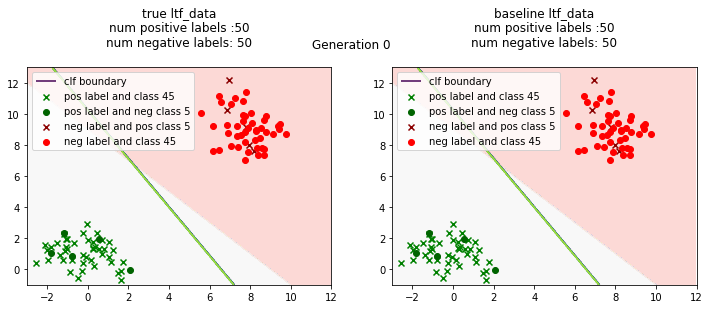

In [8]:
# Initialize the data and plot the first generation.
l.init_data()
l.plot_generation()

Nothing special in the plot. Both left and right figure are the same.

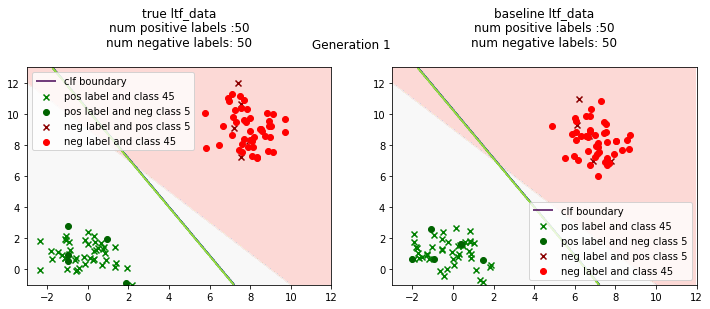

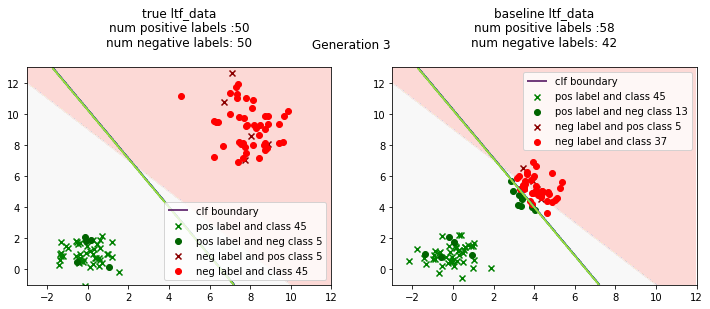

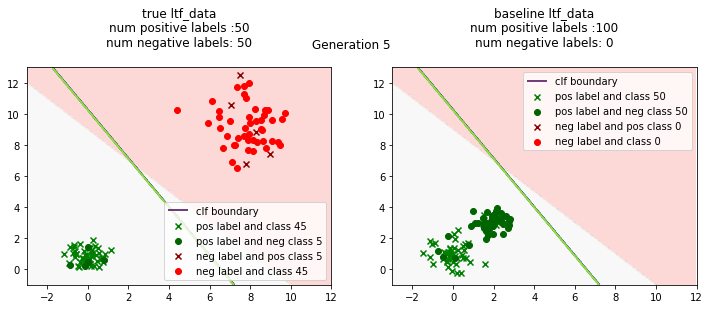

In [9]:
# Run 6 generations and plot overy second step to visualize the points moving towards the positive cluster.
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    
    if i % 2 == 0:
        l.plot_generation()

As in the previous examples, nothing changed in the true data while all individuals are positive labeled in the baseline data.

In this example, however, points moved slowly towards the positive cluster in the baseline example. It took 5 generations for all individuals to be assigned a positive label.

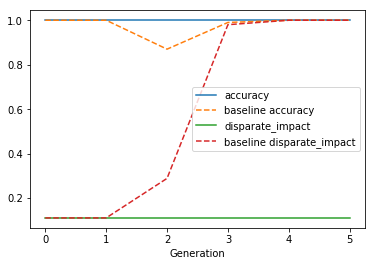

In [10]:
# Plot the metrics for the six generations.
l.plot_ltf(metric._metrics)

After 6 generations, accuracy and disparate impact are constant over time for the true data, while disparate impact improves in the baseline case and accuracy drops for a short period of two generations. The accuracy decrease is for instance visible in the plot of generation 3, when some individuals reach the decision boundary but are within the error region of the decision function.

## For Completeness: Logistic Regression
Performing the same experiment with logistic regression another decision boundary is found, which is further away from the true data generating decision boundary. This does not really impact results here, except that the accuracy decreases for a longer period of time in the baseline case.

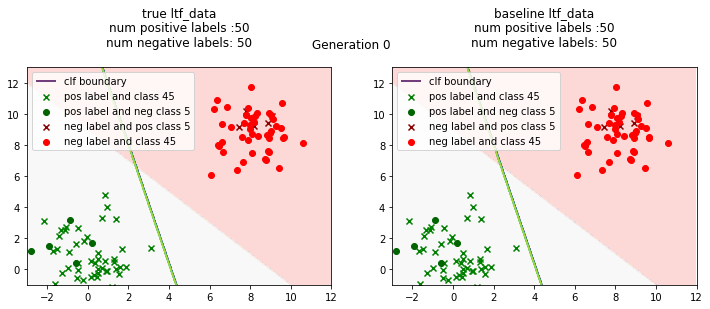

In [11]:
# New experiment where (unconstrained) logistic regression is trained as classifier.
# The purpose is to show that the new decision boundary learned by logistic regression produces 
# in an larger decrease in accuracy.
clf = CLF(LogisticRegression())
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

l.init_data()
l.plot_generation()

Logistic regression learns another decision boundary further away from the true decision boundary. This will lead to more errors in the ltf prediction as visible in the next plot.

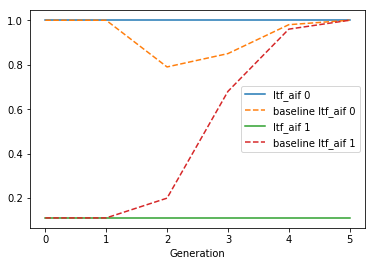

In [12]:
# Run 6 generations using logistic regression and plot results.
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    
l.plot_ltf()

In this plot, the accuracy loss is bigger compared to the SVM plot because the  decision boundary learned by logistic regression is further away from the true boundary.

## 2. Constrained Example 
The constrained simulation again uses the artificially constrained decision rule. 

In [13]:
# Fair artificial decision rule.
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

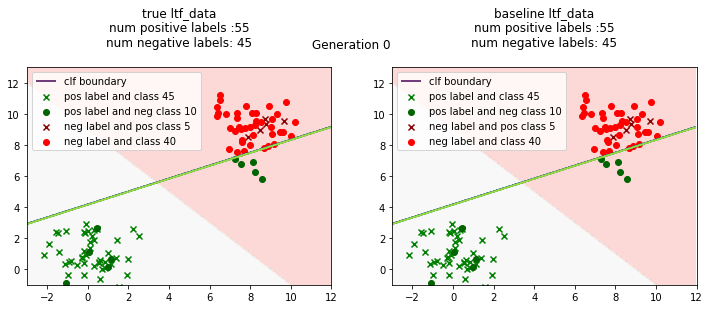

In [14]:
# Initilaize experiment and plot the first generation.
clf = FairCLF()

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

l.init_data()
l.plot_generation()

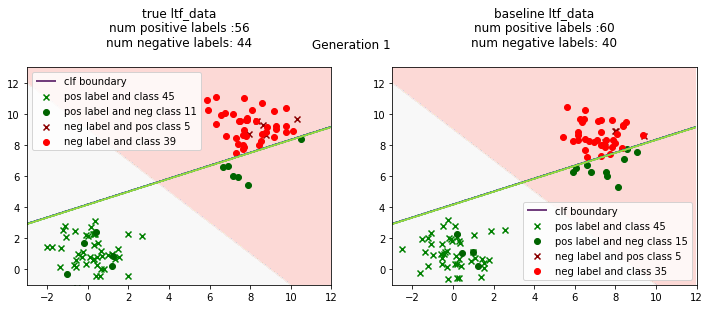

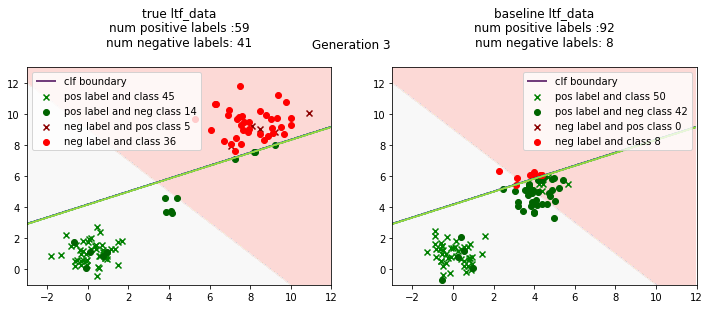

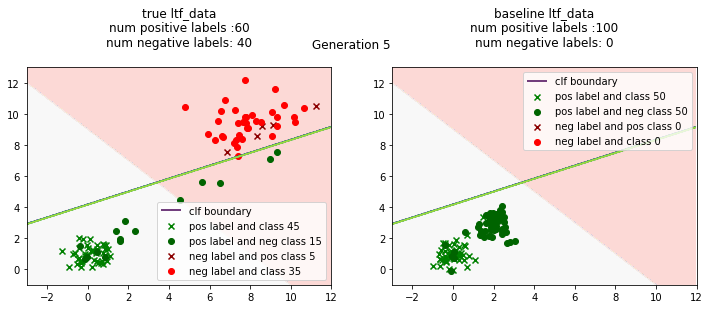

In [15]:
# Run 6 generations with the constraiiend classifier and plot data after every second iteration.
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

Again, all individuals are labeled positive after 6 generations in the baseline case, but only those individuals with a positive prediction move towards the positive cluster.

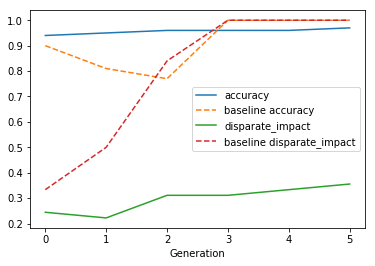

In [16]:
# Plot metrics over the 6 generations.
l.plot_ltf(metric._metrics)

The baseline data reached perfect fairness after 6 generations, while the true data is still improving. Note that the true data is still improving, because of the variance in the group. There is a small chance that individuals will cross the decision boundary in each generation. Hence, in the (very) long term all individuals will be labeled positive.

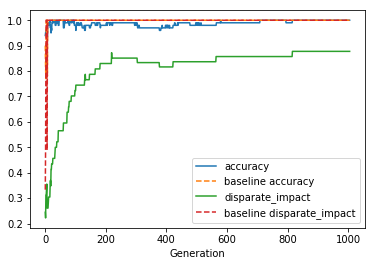

In [17]:
# Repeat the simulation for another 1000 generations.
l.run(1000)
l.plot_ltf(metric._metrics)

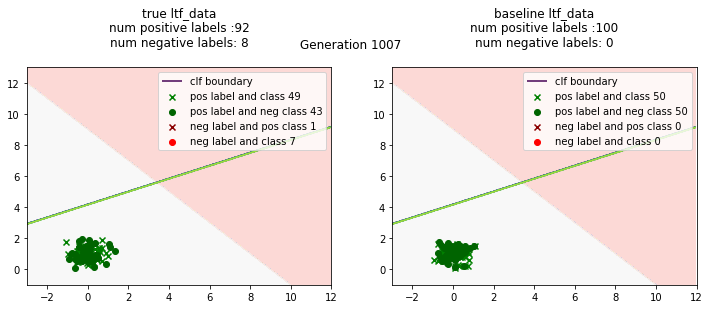

In [18]:
# Plot the data after 1000 generations.
l.plot_generation()

After 1000 generations, fairness continues to improve for the true data, while is is already perfect in the baseline data.

## 2.1 Constrained Example with Lower Variance
The setting for this example is the same as before except that the local variance is smaller now (the local variance is the deviation of the features $x_i ^{(t)}$ from the previous features $x_i ^{(t-1)}$ of individual $i$). 

Hence, the probability for individuals to randomly cross the decision boundary is much slower now and only the individuals who were lucky in the first generation will benefit from this decision rule.

In [23]:
# New generator with smaller local variance.
generator = IndDataGen(mean_pos=[0, 1],
                       mean_neg=[15, 16],
                       cov_neg= [[6, 0],[0, 7]], 
                       num_positive_label=50,
                       num_negative_label=50,
                       discrimination_factor=.9,
                       local_variance=[[0.001, 0], [0, 0.001]])

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 20], y_lim=[-1, 20])

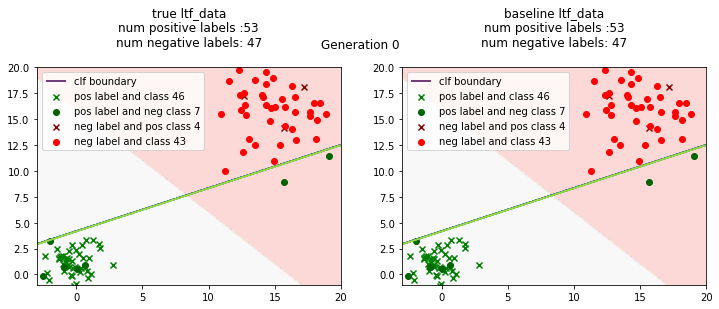

In [24]:
# Plot the initial data.
l.init_data()
l.plot_generation()

Only two individuals with a negative label are now predicted with a positive label (green circles in the red colored area).

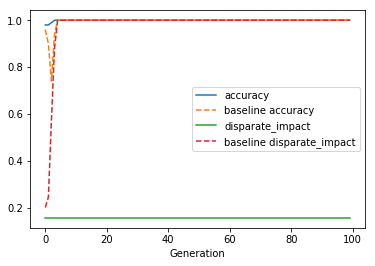

In [25]:
# Run 100 generations with the lower variance data.
l.run(100)
l.plot_ltf(metric._metrics)

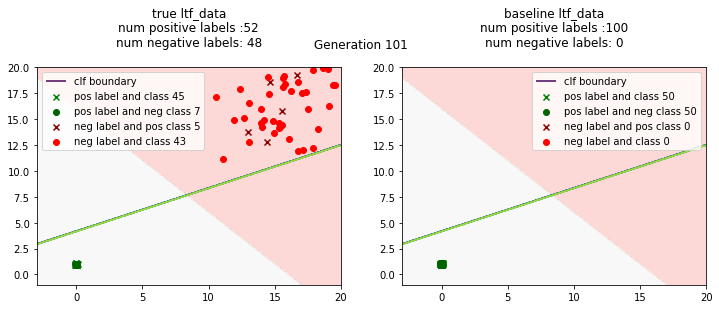

In [26]:
# Plot the data points after 100 generations with lower variance.
l.plot_generation()

In the lower variance example, individuals do not cross the decision boundary and are therefore never move towards the positive center. Only those individuals who were lucky in the first generation have moved to the positive cluster.

Note that there is a large concentration at the center of the positive cluster now due the small local variance.

### 2.1.1 Conclusion
...